## 1. Import Library yang dibutuhkan

In [1]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from nltk.util import ngrams
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import numpy as np
import math
import nltk

## 2. Import dataset

In [22]:
data = pd.read_csv("data.csv",delimiter=',')
tweet = np.asarray(data['0'])
label = np.asarray(data['1'])

## 3. Import kamus alay (kamus singkatan-singkatan)

In [23]:
kamus = pd.read_csv("kamus_alay.csv",delimiter=',')
kata_alay = np.asarray(kamus['slang'])
formal = np.asarray(kamus['formal'])

### 4. tokenisasi dataset, sekalian lower-in dan membuang tanda baca serta angka

In [24]:
data = []
for i in tweet:
    kalimat = nltk.word_tokenize(i)
    kalimat = [k.lower() for k in kalimat if k.isalpha()]
    data.append(kalimat)

### 5. normalisasi kata pada dataset dengan menggunakan kamus alay

In [25]:
for twit in range(len(data)):
    for kata in range(len(data[twit])):
        if data[twit][kata] in kata_alay:
            idxKataAlay = list(kata_alay).index(data[twit][kata])
            data[twit][kata] = formal[idxKataAlay]    

## 6. Import stopwords bahasa indonesia dan menggunakan unigram

In [26]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
tempdata = []
for twit in range(len(data)):
    temp = []
    for kata in range(len(data[twit])):
        if data[twit][kata] not in stopwords:
            temp.append(data[twit][kata])
    tempdata.append(temp)
data = tempdata

## 7. Jika ingin menggunakan Bigram, silakan jalankan code program dibawah ini. Jika tidak lewati langkah ini dan jalankan yang mencari kata-kata unik

In [27]:
bigram = []
for twit in data:
    bigram.append(list(ngrams(twit,2)))
data = bigram

## 8. mencari kata-kata unik

In [28]:
kataunik = []
for twit in data:
    for kata in twit:
        if kata not in kataunik:
            kataunik.append(kata)

## 9. membuat vector dari setiap kata dengan menggunakan tf-idf

In [29]:
idf = []
for i in range(len(kataunik)):
    counter = 0
    for j in data:
        if kataunik[i] in j:
            counter+= 1
    idf.append(counter)
    
vectorKata = []
for i in range(len(data)):
    vector = []
    for j in range(len(kataunik)):
        if (kataunik[j] in data[i]):
            vector.append(data[i].count(kataunik[j]) * (math.log(len(data)/idf[j]))) #rumus tf-idf
        else:
            vector.append(0)
    vectorKata.append(vector)

## 10. mengubah menjadi numpy array agar lebih mudah

In [30]:
vectorKata = np.asarray(vectorKata)
label = np.asarray(label)

## 11. klasifikasi

In [42]:
fold = 23
bagian = len(data)//fold

akurasi,presisi,recall = 0,0,0
for j in range(fold):
    datatest = vectorKata[j:(j+1)*bagian]
    labeltest = label[j:(j+1)*bagian]
    if (j==0):
        datatrain = vectorKata[bagian:len(data)]
        labeltrain = label[bagian:len(data)]
    elif (j==(fold-1)):
        datatrain = vectorKata[:bagian*j]
        labeltrain = label[:bagian*j]
    else:
        datatrain = np.concatenate((vectorKata[:bagian*j],vectorKata[bagian*(j+1):]),axis=0)
        labeltrain = np.concatenate((label[:bagian*j],label[bagian*(j+1):]),axis=0)
    
#     naive bayes
    clf = MultinomialNB()
    
#     random forest
#     clf = RandomForestClassifier(n_estimators=1000,max_depth=2, random_state=0)

#     SVM
#     clf = svm.SVC(kernel="linear")

#     KNN
#     clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

    
    clf.fit(datatrain, labeltrain)
    pred = clf.predict(datatest)
    totalbener,TP,FP,FN = 0,0,0,0
    for i in range(len(datatest)):
        if (pred[i]==labeltest[i]):
            if (pred[i] == 1):
                TP += 1
            totalbener += 1
        elif (pred[i] == 0 and labeltest[i] == 1):
            FN += 1
        elif (pred[i] == 1 and labeltest[i] == 0):
            FP += 1
    akurasi += ((totalbener/len(datatest))*100)
    presisi += ((TP/(TP+FP))*100)
    recall += ((TP/(TP+FN))*100)
akurasi = akurasi/fold
presisi = presisi/fold
recall = recall/fold
f1score = (2*recall*presisi)/(recall+presisi)
print ("akurasi :",akurasi)
print ("presisi :",presisi)
print ("recall  :",recall)
print ('f1score :',f1score)

akurasi : 91.93122853538149
presisi : 87.7661333645211
recall  : 99.33645389847436
f1score : 93.1935425196164


# Hasil Running Unigram - Naive Bayes

#### akurasi : 93.63%
#### presisi : 90.24%
#### recall  : 98.80%
#### f1score : 94.33%

# Hasil Running Bigram - Naive Bayes
#### akurasi : 91.93%
#### presisi : 87.77%
#### recall  : 99.34%
#### f1score : 93.19%

## Visualisasi

In [31]:
kumpulan_kata = {0: [], 1: []}
for i in range(len(data)):
    kumpulan_kata[label[i]] += data[i]

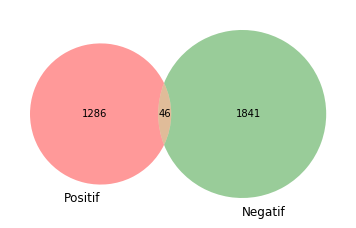

In [32]:
for i in kumpulan_kata:
    kumpulan_kata[i] = set(kumpulan_kata[i])
# persebaran fitur pada model bigram
venn2([kumpulan_kata[1], kumpulan_kata[0]], ('Positif', 'Negatif'))
plt.show()